# Определение стоимости автомобилей

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Процесс работы:
1) Выгрузить и подготовить данные для МО

2) Провести быстрый анализ (если понадобиться в дальнейшем углубиться)

3) Обучить несколько моделей и получить данные время обучения и точность

4) Анализ МО

5) Вывод

## Подготовка данных

In [ ]:
!pip install phik -q
!pip install scikit-learn==1.1.3 -q
!pip install category_encoders -q

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import phik

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,  MinMaxScaler, PolynomialFeatures, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.feature_extraction import FeatureHasher
import lightgbm as lgb

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [ ]:
data_car = pd.read_csv('/datasets/autos.csv')
data_car.head(5)                   

In [ ]:
data_car.columns = data_car.columns.str.lower()
data_car = data_car.drop_duplicates()

data_car = data_car.loc[(data_car.price >= 1000)  & (data_car.registrationyear >= 1990) & (data_car.registrationyear <= 2024) & (data_car.power<= 2200)]

Я решил убрать из данныз выбросы, это было сделано после анализа данных.
- Я прочитал, что дешевле машин чем 1000 нет
- Мощности меньше 0 лс, предположим они без двигателя
- Про дату,Я выбрал, потому что остальные или очень старые или являлись как выброс
- Мощность больше 2200 лс я убрал поскольку мощнее нет
- Остальные данные были выбраны как выброс
- Название колонок я привел к общему виду

- Тем самым я  сократил df с 300_000 до 260_000 строк

In [ ]:
data_car.describe().T

In [ ]:
box_cat = ['vehicletype', 'gearbox', 'fueltype', 'repaired'] 


plt.figure(figsize=(12, 10))

for num, title in enumerate(box_cat, 1):
    plt.subplot(3, 2, num)
    sns.countplot(
        data=data_car, 
        x=title, 
        order=data_car[title].value_counts().index
    )
    plt.title(f'Распределение {title}', fontsize=12)
    plt.xticks(rotation=45, fontsize=9)
    plt.xlabel('')
    plt.ylabel("Частота", fontsize=10)
    plt.grid(True)

plt.suptitle('Анализ категориальных признаков', fontsize=16, y=1.02)
plt.tight_layout()
plt.show();

In [ ]:
data_car['repaired'] = data_car['repaired'].fillna('no')
data_car['brand'] = data_car['brand'].fillna('un')
data_car['model'] = data_car['model'].fillna('un')
data_car['yearscar'] = 2020 - data_car['registrationyear']

У меня нет достоверных данных, поэтому я заменил на un и добавил сколько лет автомобилю

In [ ]:
#  Заполнение на основе модели и мощности
data_car['vehicletype'] = data_car.groupby('model')['vehicletype'].apply(
    lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x)
data_car['vehicletype'] = data_car['vehicletype'].fillna('other')

data_car['gearbox'] = data_car.groupby('power')['gearbox'].apply(
    lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x)
data_car['gearbox'] = data_car['gearbox'].fillna('manual')

data_car['fueltype'] = data_car.groupby('model')['fueltype'].apply(
    lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x)
data_car['fueltype'] = data_car['fueltype'].fillna('other')

box_cat = ['lpg', 'other', 'hybrid', 'cng', 'electric']
for nam in box_cat:
    data_car.loc[data_car['fueltype'] == nam, 'fueltype'] = 'other'

Здесь я заполняю nun по группам модой, параметры для группы выбранны не случайно, они имеют сильную корреляцию
И чтобы уменьшить обьем для вычеслений у 'fueltype' не значительные данные я заменил other

In [ ]:
data_car['brand_model'] = data_car['brand'] + '_' + data_car['model']

In [ ]:
data_car['brand_model_freq'] = data_car['brand_model'].map(data_car['brand_model'].value_counts(normalize=True))

In [ ]:
threshold = 0.005
rare_mask = data_car['brand_model_freq'] < threshold
data_car['brand_model_grouped'] = np.where(
    rare_mask,
    'other',
    data_car['brand_model']
)

data_car['brand_model_freq'] = data_car['brand_model_grouped'].map(
    data_car['brand_model_grouped'].value_counts(normalize=True))

In [ ]:
data_car = data_car.drop(columns=['numberofpictures', 'postalcode', 'datecrawled', 
                                  'datecreated', 'lastseen', 'registrationyear', 
                                  'registrationyear', 'registrationmonth', 'brand_model','brand', 'model', 'brand_model_grouped'], axis=1)

In [ ]:
print('Общая информация:')
print(data_car.info())

print('\n')

print('Пропуски:')
print(data_car.isnull().sum())

print('\n')

print('Явные дублликаты:')
print(data_car.duplicated().sum())

print('\n')

print('Кол-во строк и столбцов:')
print(data_car.shape)

print('\n')

print('Кол-во уникальных значений')
print(data_car.nunique())

print('\n')

print('Сводная статистика')
print(data_car.describe().T)

In [ ]:
# Проверка проверка на уникальные значения
box_title = ['vehicletype', 'gearbox', 'fueltype', 'repaired']
for title in box_title:
    print(f'Уникальные значение {title}', data_car[title].unique())

print(end='#'*20)
print('\n')

In [ ]:
numeric_cols = ['price', 'power', 'kilometer', 'yearscar', 'brand_model_freq']

sns.set(rc={'figure.figsize': (15, 10)})
ax = sns.heatmap(data_car[numeric_cols].corr(method='spearman'), annot=True, fmt='.1%', cmap='coolwarm')

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelrotation=0, labelsize=12)

plt.title('Корреляция Спирмана', fontsize=15)
plt.show();

In [ ]:
sns.set(rc={'figure.figsize':(15, 10)})
ax = sns.heatmap(data_car.phik_matrix(interval_cols=['price', 'power', 'kilometer', 'yearscar']), annot=True, fmt='.1%', cmap='Blues')

ax.tick_params(axis='x', labelrotation=70, labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.title('Фи матрица', fontsize=16)
plt.show();

Мультиколиниарности с ценой, я не нашел.

Цена имеет сильную корреляцию с мощностью 43%, с пробегом -37% и сколько лет авто -62%.

По матрице фи: 

Цена имеет сильную зависимость от модели автомобиля 48% и слабее от бренда 20%

- Где я не мог найти данные, я nun заменил на un
- Уменьшил данные у fueltype и сделать кластеризацию для brand и model
- Нашел от чего зависит цена, это модель, сколько ей лет, пробег и мощность. Эти параметры показали самое сильное влияние на цену.

# Анализ

In [ ]:
data_car.describe().T

In [ ]:
def func_hist(df, name):
    sns.set_style('whitegrid')
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    sns.histplot(data=df, x=name, bins=50, ax=axes[0], 
                 kde=True, color='blue', 
                 edgecolor='black')
    
    axes[0].set_title(f'Распределение {name}', fontsize=14)
    axes[0].set_xlabel(f'Значения {name}', fontsize=12)
    axes[0].set_ylabel('Частота', fontsize=12)
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)

    sns.boxplot(x=df[name], ax=axes[1], color='red')
    axes[1].set_title(f'Разброс значений {name}', fontsize=14)
    axes[1].set_xlabel('Значения', fontsize=12)
    axes[1].grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show();

In [ ]:
box = ['price', 'power', 'kilometer', 'yearscar', 'brand_model_freq']
for i, name in enumerate(box):
    func_hist(df=data_car, name=name)

In [ ]:
box_cat = ['vehicletype', 'gearbox', 'fueltype', 'repaired'] 


plt.figure(figsize=(12, 10))

for num, title in enumerate(box_cat, 1):
    plt.subplot(3, 2, num)
    sns.countplot(
        data=data_car, 
        x=title, 
        order=data_car[title].value_counts().index
    )
    plt.title(f'Распределение {title}', fontsize=12)
    plt.xticks(rotation=45, fontsize=9)
    plt.xlabel('')
    plt.ylabel("Частота", fontsize=10)
    plt.grid(True)

plt.suptitle('Анализ категориальных признаков', fontsize=16, y=1.02)
plt.tight_layout()
plt.show();

- Сколько лет машине имеет нормальное распределение, это может помочь для расчет алгоритмов
- Пробег в основном у всех одинаковый больше 120_000
- Машины которые были в ремонте, имеют больше значений no, может стоит убрать его убрать

## Обучение моделей

По условии задачи я должен обучить LGBMRegressor, LinearRegression, SGDRegressor, LGBMRegressor.
В начале я хотел обучить модели используя пайплан, но они начинали зависать на расчетах, поэтому в дальнейшем модели я обучал в ручную.

# LinearRegression

In [ ]:
# Для визуализации результатов
def plot_model_results(y_true, y_pred):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    residuals = y_true - y_pred
    plt.hist(residuals, bins=30)
    plt.xlabel('Ошибки')
    plt.ylabel('Частота')
    plt.title('Распределение ошибок')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Ошибки')
    plt.title('Ошибки vs Предсказания')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Для оценки модели
def evaluate_model(y_true, y_pred):
    print("\nОценка модели на тестовых данных:")
    print("-" * 40)
    print(f"R2: {r2_score(y_true, y_pred):.4f}")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    
    residuals = y_true - y_pred
    print("\nСтатистика ошибок:")
    print("-" * 40)
    print(residuals.describe())

In [ ]:
ohe_columns = ['vehicletype', 'gearbox', 'fueltype', 'repaired', 'brand_model_freq']
num_columns = ['power', 'kilometer', 'yearscar'] 

In [ ]:
X = data_car.drop('price', axis=1)
y = data_car['price']

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, 
    test_size=0.4, 
    random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size=0.3, 
    random_state=RANDOM_STATE
)

In [ ]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [ ]:
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='un')),
    ('encoder', OneHotEncoder(sparse = 'True', handle_unknown='ignore', drop='first', dtype=np.int8 ))
])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_columns),
        ('cat', categorical_transformer, ohe_columns)
    ]
)

In [ ]:
pipe_final = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [ ]:
param_grid = [
    {
        'model': [LinearRegression()],
        'preprocessor__num': [StandardScaler()]
    }
]


In [ ]:
def rmse(y_true, y_pred):
    return - np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

cv = KFold(n_splits=2, shuffle=True, random_state=RANDOM_STATE)

In [ ]:
%%time

grid_lin = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=cv, 
    scoring=rmse_scorer,   
    n_jobs=-1,
    verbose=2 
)

grid_lin.fit(X_train, y_train);

In [ ]:
print('Лучшая модель и её параметры:\n', grid_lin.best_params_)
print('Метрика RMSE для лучшей модели:', round(grid_lin.best_score_, 3))

In [ ]:
y_pred = grid_lin.predict(X_val)
plot_model_results(y_true=y_val, y_pred=y_pred)
evaluate_model(y_true=y_val, y_pred=y_pred)

In [ ]:
best_model = grid_lin.best_estimator_

coefficients = best_model.named_steps['model'].coef_

feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values('coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
coef_df.head(20).plot.barh(x='feature', y='coefficient', legend=False)
plt.title('Топ-20 факторов влияния на цену автомобиля')
plt.xlabel('Коэффициент')
plt.ylabel('Признак')
plt.tight_layout()
plt.show();

In [ ]:
time_metrics = pd.DataFrame(grid_lin.cv_results_)[
    [
        'mean_fit_time',    # Среднее время обучения (fit)
        'mean_score_time',  # Среднее время предсказания (predict)
    ]
]

fastest_to_slowest = time_metrics.sort_values('mean_fit_time')

print(time_metrics.sort_values('mean_score_time').head(10)[['mean_fit_time', 'mean_score_time']])

# Градиентный спуск

In [ ]:
pipe_sgd = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Lasso())
])

In [ ]:
param_sgd = [
    {
        'model' : [SGDRegressor()],
        'preprocessor__num': [StandardScaler()],
        'model__loss': ['huber'],
        'model__penalty': ['l1'],
        'model__alpha': [0.01],
        'model__epsilon': [1.1]
    }
]

In [ ]:
%%time

grid_sgd = GridSearchCV(
    pipe_sgd, 
    param_grid=param_sgd, 
    cv=cv, 
    scoring=rmse_scorer,   
    n_jobs=-1,
    verbose=2 
)

grid_sgd.fit(X_train, y_train);

In [ ]:
print('Лучшая модель и её параметры:\n', grid_sgd.best_params_)
print('Метрика RMSE для лучшей модели:', round(grid_sgd.best_score_, 3))

In [ ]:
y_pred_sgr = grid_sgd.predict(X_val)
plot_model_results(y_true=y_val, y_pred=y_pred_sgr)
evaluate_model(y_true=y_val, y_pred=y_pred_sgr)

In [ ]:
best_model = grid_sgd.best_estimator_

coefficients = best_model.named_steps['model'].coef_

feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values('coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
coef_df.head(20).plot.barh(x='feature', y='coefficient', legend=False)
plt.title('Топ-20 факторов влияния на цену автомобиля')
plt.xlabel('Коэффициент')
plt.ylabel('Признак')
plt.tight_layout()
plt.show();

In [ ]:
time_metrics = pd.DataFrame(grid_sgd.cv_results_)[
    [
        'mean_fit_time',    # Среднее время обучения (fit)
        'mean_score_time',  # Среднее время предсказания (predict)
    ]
]

fastest_to_slowest = time_metrics.sort_values('mean_fit_time')

print(time_metrics.sort_values('mean_score_time').head(10)[['mean_fit_time', 'mean_score_time']])

# RandomForestRegressor

In [ ]:
pipe_forest = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor())
])

In [ ]:
param_forest = [{
    'model': [RandomForestRegressor()],
    'preprocessor__num': [StandardScaler()],
    'model__n_estimators': [100],
    'model__max_depth': [12],
    'model__random_state': [42],
    'model__min_samples_split': [7],
    'model__min_samples_leaf': [5]
}]

In [ ]:
%%time

grid_forest = GridSearchCV(
    pipe_forest, 
    param_grid=param_forest, 
    cv=cv, 
    scoring=rmse_scorer,   
    n_jobs=-1,
    verbose=2 
)

grid_forest.fit(X_train, y_train);

In [ ]:
print('Лучшая модель и её параметры:\n', grid_forest.best_params_)
print('Метрика RMSE для лучшей модели:', round(grid_forest.best_score_, 3))

In [ ]:
y_pred_forest = grid_forest.predict(X_val)
plot_model_results(y_true=y_val, y_pred=y_pred_forest)
evaluate_model(y_true=y_val, y_pred=y_pred_forest)

In [ ]:
best_model = grid_forest.best_estimator_

importances = best_model.named_steps['model'].feature_importances_

feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
importance_df.head(20).plot.barh(x='feature', y='importance', legend=False)
plt.title('Топ-20 важных признаков (RandomForest)')
plt.xlabel('Важность (Gini importance)')
plt.ylabel('Признак')
plt.tight_layout()
plt.show();

In [ ]:
time_metrics = pd.DataFrame(grid_forest.cv_results_)[
    [
        'mean_fit_time',    # Среднее время обучения (fit)
        'mean_score_time',  # Среднее время предсказания (predict)
    ]
]

fastest_to_slowest = time_metrics.sort_values('mean_fit_time')

print(time_metrics.sort_values('mean_score_time').head(10)[['mean_fit_time', 'mean_score_time']])

# LightGBM

In [ ]:
X_train[ohe_columns] = X_train[ohe_columns].astype('category')
X_val[ohe_columns] = X_val[ohe_columns].astype('category')
X_test[ohe_columns] = X_test[ohe_columns].astype('category')

In [ ]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 60,          
    'max_depth': 50,           
    'learning_rate': 0.01,
    'n_estimators': 500,
    'min_data_in_leaf': 20,
}

In [ ]:
model_LGB = lgb.LGBMRegressor(**params)

In [ ]:
%%time
model_LGB.fit(
    X_train, y_train,
    eval_metric='rmse'
)

In [ ]:
%%time
predict_LGB= model_LGB.predict(X_val)
plot_model_results(y_true=y_val, y_pred=predict_LGB)
evaluate_model(y_true=y_val, y_pred=predict_LGB)

In [ ]:
features=X_val.columns
importances = model_LGB.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(11, 5))
plt.title('Важность функции')
plt.barh(range(len(indices)), importances[indices], color='#6495ED', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Относительная важность')
plt.show()

feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)
feat_importances = feat_importances.to_frame()
feat_importances.columns=['Относительная важность']
display(feat_importances)

Всю информацию я написал в выводе.

## Анализ моделей

# Обьяснение

|Метрика  |Значение	|Что означает|
|---------|---------|---------------------------------|
|user	  |17.7 s	|Время, потраченное вашим кодом на выполнение (полезная работа CPU)|
|         |         |                                                                |
|sys	  |5.76 s	|Время, потраченное системой (например, чтение файлов, вызовы ОС)|
|         |         |                                         |
|total	  |23.5 s	|Сумма user + sys (общее время работы CPU)|
|         |         |                                         |
|Wall time|23.8 s	|Реальное время выполнения (как если бы вы засекли его на часах)|



In [ ]:
%%time
predict= model_LGB.predict(X_test)
plot_model_results(y_true=y_test, y_pred=predict)
evaluate_model(y_true=y_test, y_pred=predict)

# Вывод

Добрый день, коллеги. Я провел анализ данных, которые предоставил нам клиент.

1) Обработка данных:

- Я прочитал, что дешевле машин чем 1000 нет
- Выбрал даты больше 1990
- Привел данные к общему виду
- Название колонок я привел к общему виду
- Тем самым я  сократил df с 300_000 до 260_000 строк

2) Анализ:
Корреляция

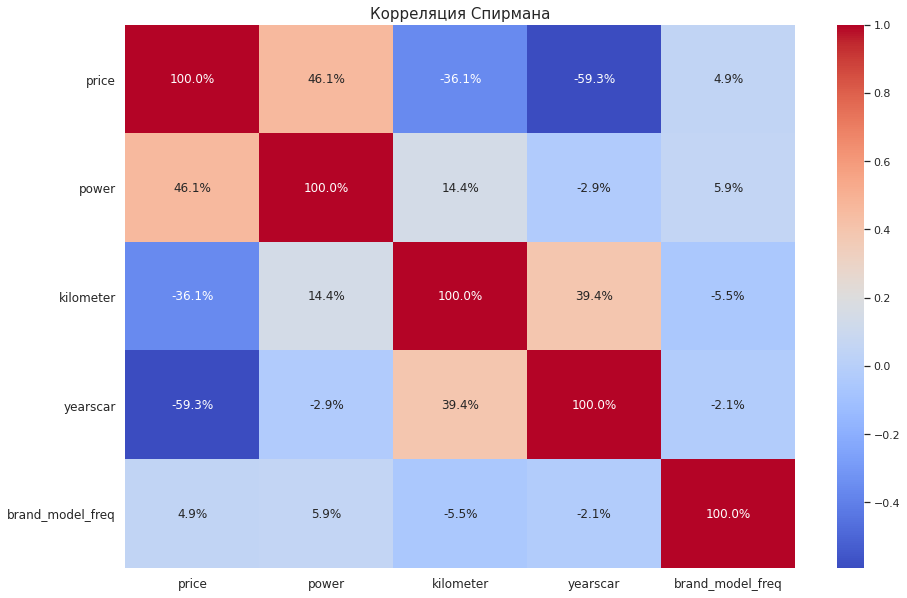


Матрица фи

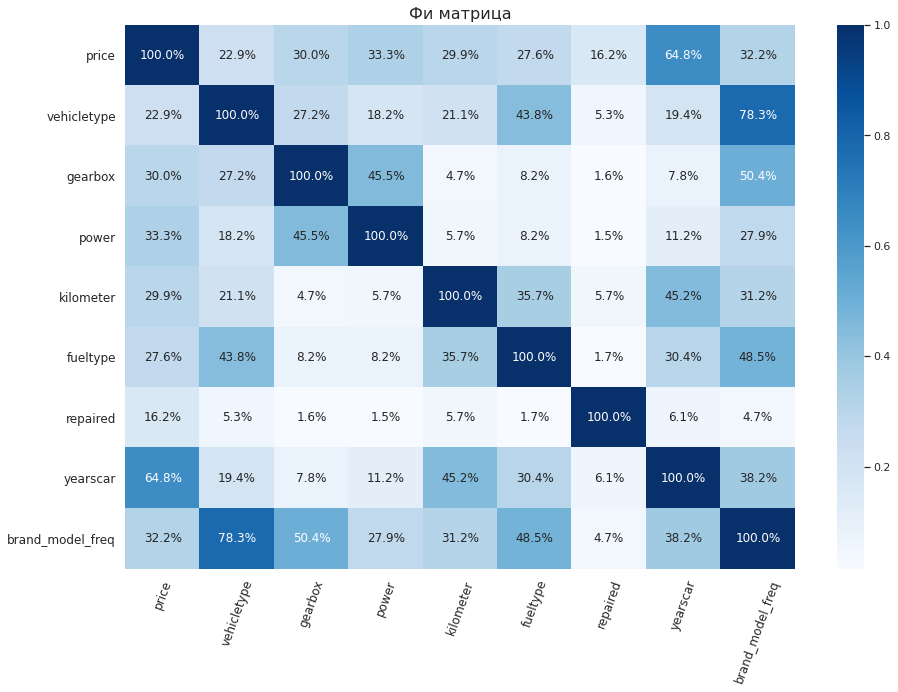

- Мультиколиниарности с ценой, я не нашел.
- Цена имеет сильную корреляцию с мощностью 46%, с пробегом -36% и сколько лет авто -59%.
- Цена имеет сильную зависимость от модели автомобиля 32%

Общие данные:

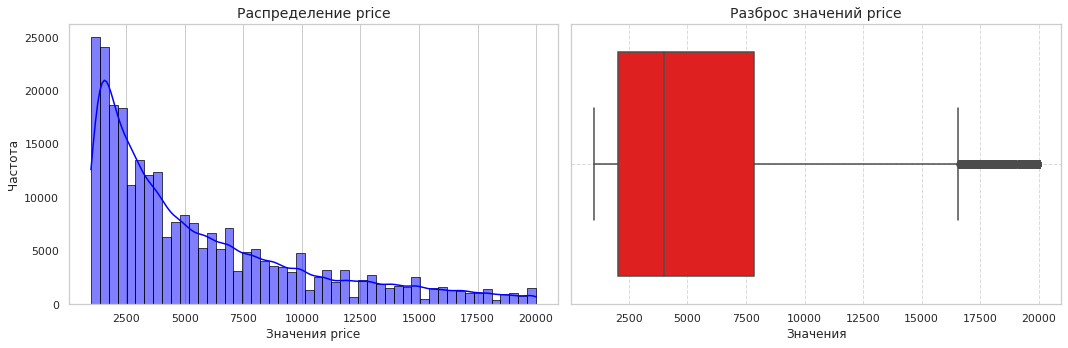

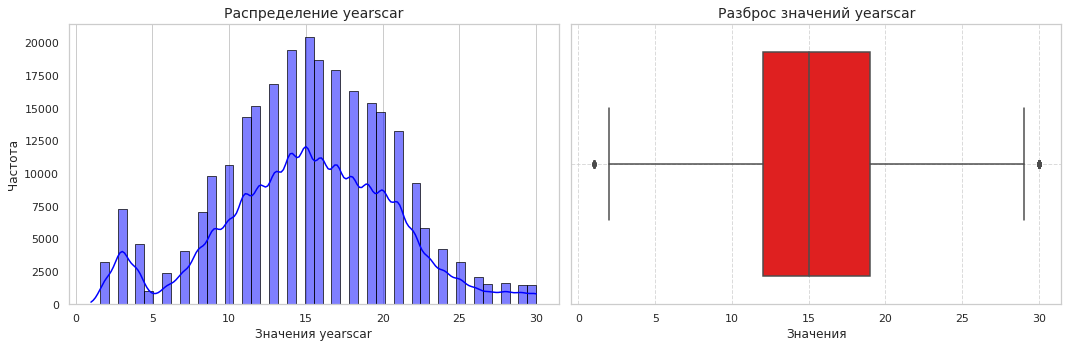

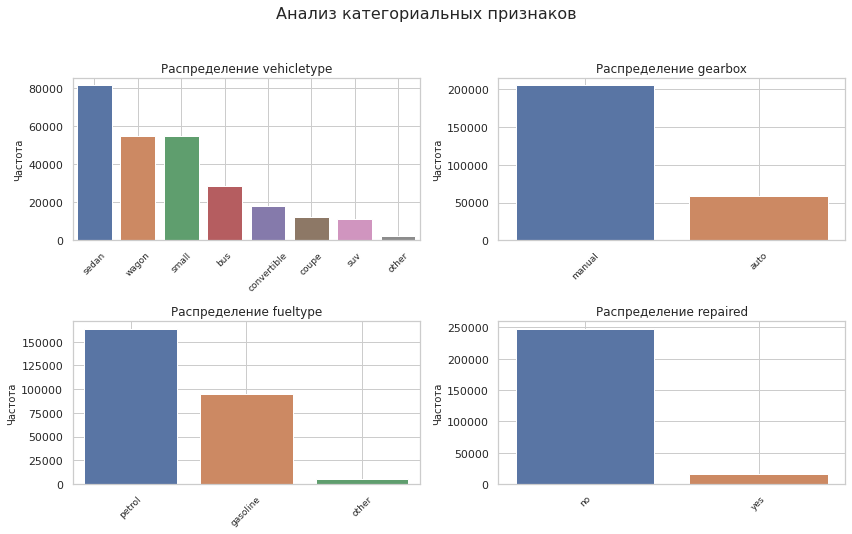


- Сколько лет машине имеет нормальное распределение, это может помочь для расчет алгоритмов
- Пробег в основном у всех одинаковый больше 120_000
- Машины которые были в ремонте, имеют больше значений no, может стоит убрать его убрать

В своей работе по обучении модели я использовал LinearRegression(), SGDRegressor(), RandomForestRegressor, LGBMRegressor().
Забегая вперед лучше всеего себя показала модель LGBMRegressor(), хуже всего SGDRegressor(), после обработки полиномилной регресси линейная регрессия лучше предсказала цену. Предлагаю их и рассмотреть. Только RandomForestRegressor, LGBMRegressor() выполнили пожелание клиента RMSE < 2500 и быстро обучаются.

RandomForestRegressor

Оценка модели на валидационых данных:
- R2: 0.8169
- MSE: 3740586.1430
- RMSE: 1934.0595
- MAE: 1305.4151

- Время обучении модели 60.747543 сек
- Время предсказания 0.644231 сек


Плюсы Градиентного метода

Оценка модели на тестовых данных:
- R2: 0.8347
- MSE: 3350945.8883
- RMSE: 1830.5589
- MAE: 1222.9871

- Время обучения: 3min 7s
- Время предсказания: 11.5 s

Градиент работает дольше, но не намного, в пределах разумного времени.

Для дальнейшей работы над проектом предлагаю остановиться на градиенте и уже подобрать точные гипер параметры или использовать новые данные для обучения ради повышения точности.